In [1]:
#!pip install WordCloud

In [2]:
# To store the data
import pandas as pd

# Time converter
import datetime

# To do linear algebra
import numpy as np

# To create plots
import matplotlib.pyplot as plt # data visualization library
import seaborn as sns
sns.set_style('whitegrid')
from wordcloud import WordCloud, STOPWORDS #used to generate world cloud

# To create interactive plots
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# To shift lists
from collections import deque

# To compute similarities between vectors
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

# To use recommender systems
import surprise as sp
from surprise.model_selection import cross_validate

# To stack sparse matrices
from scipy.sparse import vstack
from scipy import sparse
from scipy.sparse import csr_matrix

# A. Movie Data Exploratory Data Analysis (EDA)

* ## 1. Known ratings data analysis

In [3]:
train=pd.read_csv('../input/edsa-recommender-system-predict/train.csv')
train

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837
...,...,...,...,...
10000033,136395,99114,5.0,1521235092
10000034,140078,553,3.0,1002580977
10000035,154807,56782,4.0,1227674807
10000036,85805,327,4.0,1479921530


* ### 1.1 General overview

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


In [5]:
train.describe()['rating']

count    1.000004e+07
mean     3.533395e+00
std      1.061124e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [6]:
train['rating'].value_counts()

4.0    2652977
3.0    1959759
5.0    1445230
3.5    1270642
4.5     880516
2.0     656821
2.5     505578
1.0     311213
1.5     159731
0.5     157571
Name: rating, dtype: int64

In [7]:
#train['date'] = pd.to_datetime(train['timestamp'],unit='s')
#train.drop('timestamp', axis=1, inplace=True)

In [8]:
train['date'] = train['timestamp'].apply(lambda d: datetime.datetime.fromtimestamp(int(d)).strftime('%Y-%m-%d'))

In [9]:
train.drop('timestamp', axis=1, inplace=True)

In [10]:
train['date'] = pd.to_datetime(train['date'])

In [11]:
train.sort_values(by='date')

,userId,movieId,rating,date
5065562,2262,47,5.0,1995-01-09
5844343,109832,34,5.0,1996-01-29
7116900,71732,19,1.0,1996-01-29
6479716,102689,19,4.0,1996-01-29
4358702,102689,58,5.0,1996-01-29
...,...,...,...,...
783211,18580,33437,4.0,2019-11-21
1908095,87707,858,4.0,2019-11-21
2948247,41191,194947,2.5,2019-11-21
8362960,24696,70286,4.5,2019-11-21


In [12]:
# check for NULLs
print("No. of NULL values in our dataframe : ", sum(train.isnull().any()))

No. of NULL values in our dataframe :  0


In [13]:
# check for duplicates
dup_bool = train.duplicated(['userId','movieId','rating'])
dups = sum(dup_bool)
print("There are {} duplicate rating entries in the data...".format(dups))

There are 0 duplicate rating entries in the data...


In [14]:
print("Overview of training data")
print("-"*50)
print("\nTotal No. of ratings :",train.shape[0])
print("Total No. of Users   :", len(np.unique(train.userId)))
print("Total No. of movies  :", len(np.unique(train.movieId)))

Overview of training data
--------------------------------------------------

Total No. of ratings : 10000038
Total No. of Users   : 162541
Total No. of movies  : 48213


In [15]:
test=pd.read_csv('../input/edsa-recommender-system-predict/test.csv')
test

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318
...,...,...
5000014,162541,4079
5000015,162541,4467
5000016,162541,4980
5000017,162541,5689


In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


In [17]:
print("Overview of test data")
print("-"*50)
print("\nTotal No. of ratings :",test.shape[0])
print("Total No. of Users   :", len(np.unique(test.userId)))
print("Total No. of movies  :", len(np.unique(test.movieId)))

Overview of test data
--------------------------------------------------

Total No. of ratings : 5000019
Total No. of Users   : 162350
Total No. of movies  : 39643


* ### 1.2 Basic distributions and proportions

<function matplotlib.pyplot.show(*args, **kw)>

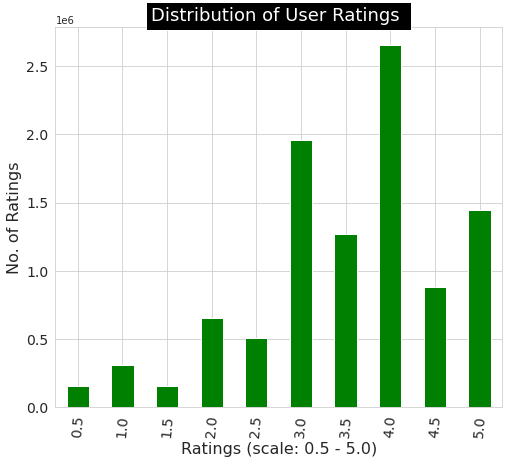

In [18]:
train.groupby('rating')['userId'].count().plot(kind = 'bar', color = 'g',figsize = (8,7))
plt.xticks(rotation=85, fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Ratings (scale: 0.5 - 5.0)', fontsize=16)
plt.ylabel('No. of Ratings', fontsize=16)
plt.title('Distribution of User Ratings ',bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 18)
plt.show

In [19]:
# Calculate and categorise ratings proportions
a = len(train.loc[train['rating']== 0.5]) / len(train)
b = len(train.loc[train['rating']==1.0]) / len(train)
c = len(train.loc[train['rating']==1.5]) / len(train)
d = len(train.loc[train['rating']==2.0]) / len(train)
low_ratings= a+b+c+d
e = len(train.loc[train['rating']==2.5]) / len(train)
f = len(train.loc[train['rating']== 3.0]) / len(train)
g = len(train.loc[train['rating']==3.5]) / len(train)
medium_ratings= e+f+g
h = len(train.loc[train['rating']==4.0]) / len(train)
i = len(train.loc[train['rating']==4.5]) / len(train)
j = len(train.loc[train['rating']==5.0]) / len(train)
high_ratings= h+i+j
# Sanity check for checking if ratings proportions equal 100 percent
low_ratings+medium_ratings+high_ratings==1

True

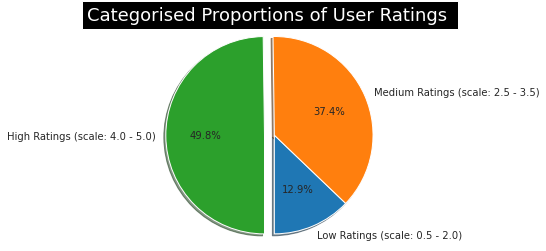

In [20]:
# To view proportions of ratings categories, it is best practice to use pie charts
# Where the slices will be ordered and plotted clockwise:
labels = 'Low Ratings (scale: 0.5 - 2.0)', 'Medium Ratings (scale: 2.5 - 3.5)', 'High Ratings (scale: 4.0 - 5.0)'
sizes = [low_ratings, medium_ratings,  high_ratings]
explode = (0, 0, 0.1)  # Only "explore" the 3rd slice (i.e. 'Anti')

# Create pie chart with the above labels and calculated class proportions as inputs
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=270)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Categorised Proportions of User Ratings ',bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 18)
plt.show()

In [21]:
train

,userId,movieId,rating,date
0,5163,57669,4.0,2018-02-11
1,106343,5,4.5,2008-03-23
2,146790,5459,5.0,2004-02-08
3,106362,32296,2.0,2015-02-04
4,9041,366,3.0,1996-05-29
...,...,...,...,...
10000033,136395,99114,5.0,2018-03-16
10000034,140078,553,3.0,2001-10-08
10000035,154807,56782,4.0,2008-11-26
10000036,85805,327,4.0,2016-11-23


* ### 1.3 Ratings trend analysis

In [22]:
pd.options.mode.chained_assignment = None  # default='warn'

train['day_of_week'] = train['date'].dt.day_name()

train.sample(10)

,userId,movieId,rating,date,day_of_week
2226894,120181,2762,4.0,2004-02-16,Monday
8967590,94650,2584,0.5,2007-10-17,Wednesday
3359471,130624,7361,5.0,2010-08-24,Tuesday
5547702,111258,1208,4.0,2012-01-13,Friday
3234199,157751,282,3.5,2006-04-28,Friday
8099643,75526,128360,3.5,2017-08-05,Saturday
9357336,43217,33794,4.0,2018-08-28,Tuesday
775130,118402,1653,3.0,2000-08-13,Sunday
962133,137145,2991,4.0,2001-12-01,Saturday
5224098,34750,368,3.0,2005-11-16,Wednesday


In [23]:
# method to make axes more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + 'K'
    elif units == 'm':
        return str(num/10**6) + 'M'
    elif units == 'b':
        return str(num/10**9) +  'B'

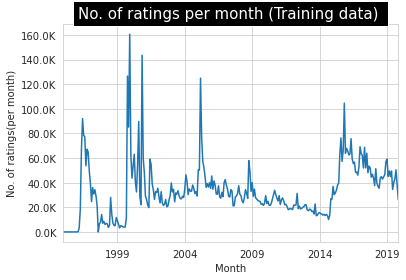

In [24]:
ax = train.resample('m', on='date')['rating'].count().plot()
#ax.set_title('No. of ratings per month (Training data)')
plt.title('No. of ratings per month (Training data) ',bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 15)
plt.xlabel('Month')
plt.ylabel('No. of ratings(per month)')
ax.set_yticklabels([human(item, 'k') for item in ax.get_yticks()])
#ax.annotate()
plt.show()

In [25]:
no_of_rated_movies_per_user = train.groupby(by='userId')['rating'].count().sort_values(ascending=False)

no_of_rated_movies_per_user.head()

userId
72315     12952
80974      3680
137293     3588
33844      3208
20055      3050
Name: rating, dtype: int64

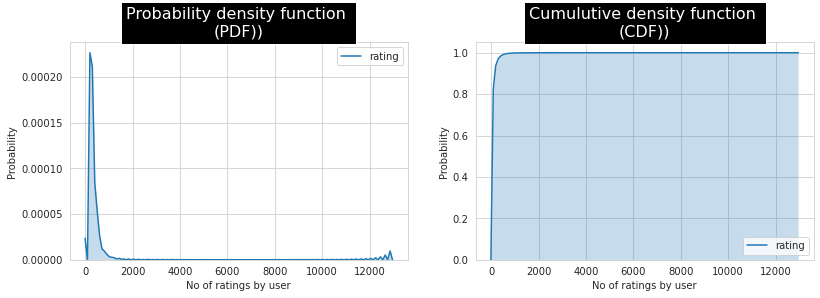

In [26]:
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.ylabel('Probability')
plt.xlabel('No of ratings by user')
#plt.title("PDF")
plt.title("Probability density function \n(PDF))",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 16)

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.ylabel('Probability')
plt.xlabel('No of ratings by user')
#plt.title('CDF')
plt.title("Cumulutive density function \n(CDF))",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 16)

plt.show()

In [27]:
no_of_rated_movies_per_user.describe()

count    162541.000000
mean         61.523173
std         107.410889
min           1.000000
25%          14.000000
50%          28.000000
75%          65.000000
max       12952.000000
Name: rating, dtype: float64

In [28]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

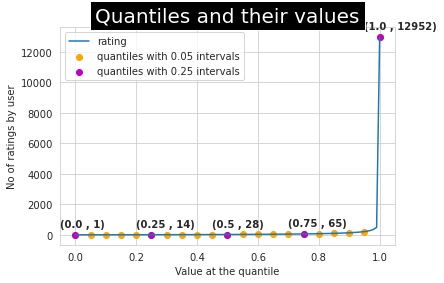

In [29]:

plt.title("Quantiles and their values",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 20)
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')


plt.show()

In [30]:
quantiles[::5]

0.00        1
0.05        8
0.10       10
0.15       11
0.20       13
0.25       14
0.30       16
0.35       19
0.40       21
0.45       25
0.50       28
0.55       33
0.60       39
0.65       45
0.70       54
0.75       65
0.80       81
0.85      104
0.90      142
0.95      222
1.00    12952
Name: rating, dtype: int64

In [31]:
print('\n No of ratings at last 5th percentile : {}\n'.format(sum(no_of_rated_movies_per_user>= 222)) )


 No of ratings at last 5th percentile : 8182



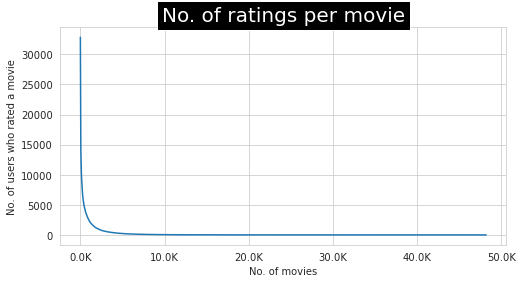

In [32]:
no_of_ratings_per_movie = train.groupby(by='movieId')['rating'].count().sort_values(ascending=False)


fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title("No. of ratings per movie",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 20)
plt.xlabel('No. of movies')
plt.ylabel('No. of users who rated a movie')
ax.set_xticklabels([human(item, 'k') for item in ax.get_xticks()])
#ax.set_xticklabels([])

plt.show()

****Earmark section on latent factors here*****

In [33]:
result = train.groupby(["day_of_week"]).aggregate(np.mean).reset_index().sort_values('rating')

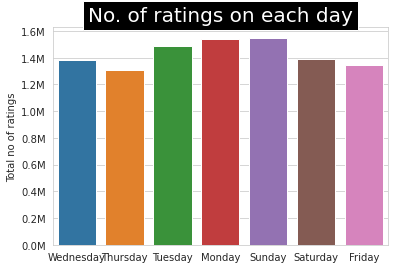

In [34]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data=train, ax=ax, order=result['day_of_week'])
plt.title("No. of ratings on each day",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 20)
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

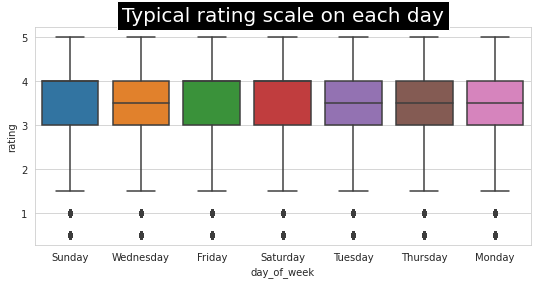

In [35]:
fig = plt.figure(figsize=plt.figaspect(.45))
plt.title("Typical rating scale on each day",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 20)
sns.boxplot(y='rating', x='day_of_week', data=train)
plt.show()

In [36]:
avg_week_df = train.groupby(by=['day_of_week'])['rating'].mean()
print(" Average ratings")
print("-"*30)
print(avg_week_df)
print("\n")

 Average ratings
------------------------------
day_of_week
Friday       3.542188
Monday       3.533597
Saturday     3.540887
Sunday       3.539399
Thursday     3.526199
Tuesday      3.527152
Wednesday    3.523858
Name: rating, dtype: float64




In [37]:
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

if os.path.isfile('train_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    train_sparse_matrix = sparse.csr_matrix((train.rating.values, (train.userId.values,
                                               train.movieId.values)),)
    
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
    print('Done..\n')

We are creating sparse_matrix from the dataframe..
Done. It's shape is : (user, movie) :  (162542, 209172)
Saving it into disk for furthur usage..
Done..



In [38]:
us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Train matrix : 99.97058746194108 % 


In [39]:
test['rating']=np.nan

In [40]:
if os.path.isfile('test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    test_sparse_matrix = sparse.csr_matrix((test.rating.values, (test.userId.values,
                                               test.movieId.values)))
    
    print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
    print('Saving it into disk for future use..')
    # save it into disk
    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
    print('Done..\n')

We are creating sparse_matrix from the dataframe..
Done. It's shape is : (user, movie) :  (162542, 209164)
Saving it into disk for future use..
Done..



In [41]:
us,mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Test matrix : 99.98529316849252 % 


In [42]:

# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

In [43]:
train_averages = dict()
# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.5333951730983424}

In [44]:
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 :',train_averages['user'][10])


Average rating of user 10 : 3.5526315789473686


In [45]:
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('\n Average rating of movie 15 :',train_averages['movie'][15])


 Average rating of movie 15 : 2.7363636363636363


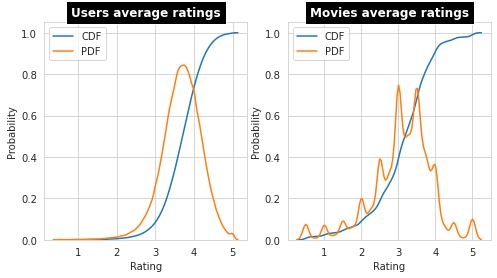

In [46]:
# draw pdfs for average rating per user and average
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))
#fig.suptitle('Avg Ratings per User and per Movie', fontsize=15)
#plt.title("Typical rating scale on each day",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 20)

ax1.set_title('Users average ratings',bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 12, fontweight='bold')
# get the list of average user ratings from the averages dictionary..
user_averages = [rat for rat in train_averages['user'].values()]
ax1.set(xlabel='Rating', ylabel = 'Probability')
sns.distplot(user_averages, ax=ax1, hist=False, 
             kde_kws=dict(cumulative=True), label='CDF')
sns.distplot(user_averages, ax=ax1, hist=False,label='PDF')


ax2.set_title('Movies average ratings',bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 12, fontweight='bold')
# get the list of movie_average_ratings from the dictionary..
movie_averages = [rat for rat in train_averages['movie'].values()]
ax2.set(xlabel='Rating', ylabel = 'Probability')
sns.distplot(movie_averages, ax=ax2, hist=False, 
             kde_kws=dict(cumulative=True), label='CDF')
sns.distplot(movie_averages, ax=ax2, hist=False, label='PDF')


In [47]:
total_users = len(np.unique(train.userId))+len(np.unique(test.userId))
users_train = len(train_averages['user'])
new_users = total_users - users_train

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo. of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 324891

Number of Users in Train data : 162541

No. of Users that didn't appear in train data: 162350(49.97 %) 
 


In [48]:
total_movies = len(np.unique(train.movieId))+len(np.unique(test.movieId))
movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train

print('\nTotal number of Movies  :', total_movies)
print('\nNumber of Users in Train data :', movies_train)
print("\nNo. of Movies that didn't appear in train data: {}({} %) \n ".format(new_movies,
                                                                        np.round((new_movies/total_movies)*100, 2)))


Total number of Movies  : 87856

Number of Users in Train data : 48213

No. of Movies that didn't appear in train data: 39643(45.12 %) 
 


In [49]:
from sklearn.metrics.pairwise import cosine_similarity


def compute_user_similarity(sparse_matrix, compute_for_few=False, top = 100, verbose=False, verb_for_n_rows = 20,
                            draw_time_taken=True):
    no_of_users, _ = sparse_matrix.shape
    # get the indices of  non zero rows(users) from our sparse matrix
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind)) # we don't have to
    time_taken = list() #  time taken for finding similar users for an user..
    
    # we create rows, cols, and data lists.., which can be used to create sparse matrices
    rows, cols, data = list(), list(), list()
    if verbose: print("Computing top",top,"similarities for each user..")
    
    start = datetime.now()
    temp = 0
    
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp+1
        prev = datetime.now()
        
        # get the similarity row for this user with all other users
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        # We will get only the top ''top'' most similar users and ignore rest of them..
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        
        # add them to our rows, cols and data
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("computing done for {} users [  time elapsed : {}  ]"
                      .format(temp, datetime.now()-start))
            
        
    # lets create sparse matrix out of these and return it
    if verbose: print('Creating Sparse matrix from the computed similarities')
    #return rows, cols, data
    
    if draw_time_taken:
        plt.title("Sparse matrix creation duration",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 16)
        plt.plot(time_taken, label = 'time taken for each user')
        plt.plot(np.cumsum(time_taken), label='Total time')
        plt.legend(loc='best')
        plt.xlabel('User')
        plt.ylabel('Time (seconds)')
        plt.show()
        
    return sparse.csr_matrix((data, (rows, cols)), shape=(no_of_users, no_of_users)), time_taken

Computing top 100 similarities for each user..
computing done for 20 users [  time elapsed : 0:00:06.707471  ]
computing done for 40 users [  time elapsed : 0:00:13.344314  ]
computing done for 60 users [  time elapsed : 0:00:20.019163  ]
computing done for 80 users [  time elapsed : 0:00:26.759164  ]
computing done for 100 users [  time elapsed : 0:00:34.140832  ]
Creating Sparse matrix from the computed similarities


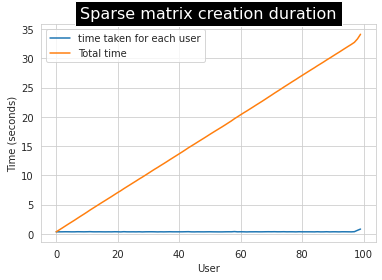

----------------------------------------------------------------------------------------------------
Time taken : 0:00:38.180276


In [50]:
from datetime import datetime

d1 = datetime.now()
start = d1
u_u_sim_sparse, _ = compute_user_similarity(train_sparse_matrix, compute_for_few=True, top = 100,
                                                     verbose=True)
print("-"*100)
print("Time taken :",datetime.now()-start)

In [51]:
from datetime import datetime
from sklearn.decomposition import TruncatedSVD

start = datetime.now()

# initilaize the algorithm with some parameters..
# All of them are default except n_components. n_itr is for Randomized SVD solver.

trunc_svd = TruncatedSVD(n_components=1000, algorithm='randomized', random_state=15)
trunc_svd = trunc_svd.fit(train_sparse_matrix)

print(datetime.now()-start)

0:05:36.278470


In [52]:
#svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
#svd.fit(train_sparse_matrix)
#TruncatedSVD(n_components=5, n_iter=7, random_state=42)

#print(svd.explained_variance_ratio_)

#print(svd.explained_variance_ratio_.sum())

#print(svd.singular_values_)

In [53]:
expl_var = np.cumsum(trunc_svd.explained_variance_ratio_)

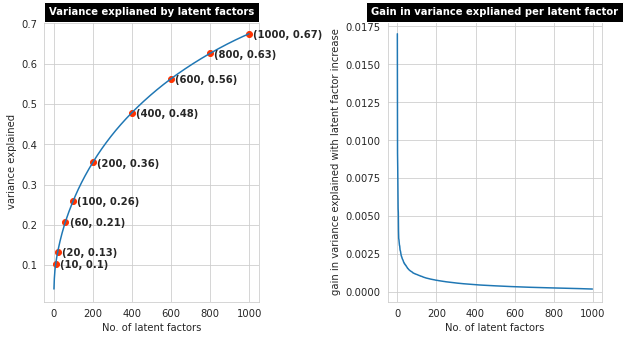

In [54]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.4))

ax1.set_title("Variance explianed by latent factors",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 10,fontweight='bold')

ax1.set_ylabel("variance explained", fontsize=10)
ax1.set_xlabel("No. of latent factors", fontsize=10)
ax1.plot(expl_var)
# annote some (latentfactors, expl_var) to make it clear
#ind = [10 ,50, 200, 500]
#ind = [1, 2,4,8,20, 60, 100, 200, 300, 400, 500]
ind = [10, 20, 60, 100, 200, 400, 600, 800, 1000]
ax1.scatter(x = [i-1 for i in ind], y = expl_var[[i-1 for i in ind]], c='#ff3300')
for i in ind:
    ax1.annotate(s ="({}, {})".format(i,  np.round(expl_var[i-1], 2)), xy=(i-1, expl_var[i-1]),
                xytext = ( i+20, expl_var[i-1] - 0.01), fontweight='bold')

change_in_expl_var = [expl_var[i+1] - expl_var[i] for i in range(len(expl_var)-1)]
ax2.plot(change_in_expl_var)


ax2.set_title("Gain in variance explianed per latent factor",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 10,fontweight='bold')
#ax2.set_ylabel("gain in variance explained with single additional LF", fontsize=10)
#ax2.yaxis.set_label_position("right")
ax2.set_ylabel("gain in variance explained with latent factor increase", fontsize=10)
ax2.set_xlabel("No. of latent factors", fontsize=10)


plt.subplots_adjust(wspace=0.6, top=1.10)
plt.show()

In [55]:
for i in ind:
    print("({}, {})".format(i, np.round(expl_var[i-1], 2)))

(10, 0.1)
(20, 0.13)
(60, 0.21)
(100, 0.26)
(200, 0.36)
(400, 0.48)
(600, 0.56)
(800, 0.63)
(1000, 0.67)


* ## 2 Genre trend analysis

In [56]:
import pandas as pd

# To create plots
import matplotlib.pyplot as plt # data visualization library
import seaborn as sns
sns.set_style('whitegrid')
from wordcloud import WordCloud, STOPWORDS #used to generate world cloud

In [57]:
movies=pd.read_csv('../input/edsa-recommender-system-predict/movies.csv')
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [58]:
#define a function that counts the number of times each genre appear:
def count_word(df, ref_col, lister):
    keyword_count = dict()
    for s in lister: keyword_count[s] = 0
    for lister_keywords in df[ref_col].str.split('|'):
        if type(lister_keywords) == float and pd.isnull(lister_keywords): continue
        for s in lister_keywords: 
            if pd.notnull(s): keyword_count[s] += 1
    # convert the dictionary in a list to sort the keywords  by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [59]:
#here we  make census of the genres:
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [60]:
#counting how many times each of genres occur:
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences

[['Drama', 25606],
 ['Comedy', 16870],
 ['Thriller', 8654],
 ['Romance', 7719],
 ['Action', 7348],
 ['Horror', 5989],
 ['Documentary', 5605],
 ['Crime', 5319],
 ['(no genres listed)', 5062],
 ['Adventure', 4145],
 ['Sci-Fi', 3595],
 ['Children', 2935],
 ['Animation', 2929],
 ['Mystery', 2925],
 ['Fantasy', 2731],
 ['War', 1874],
 ['Western', 1399],
 ['Musical', 1054],
 ['Film-Noir', 353],
 ['IMAX', 195]]

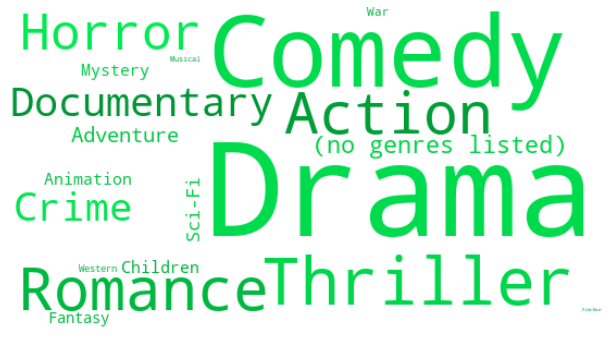

In [61]:
# Function that control the color of the words
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


#Finally, the result is shown as a wordcloud:
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='white', 
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

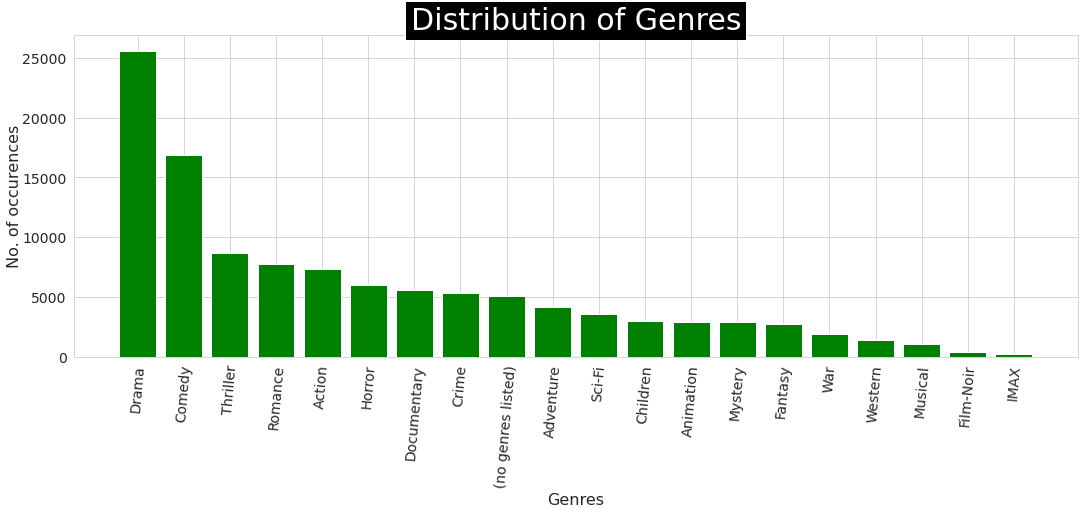

In [62]:
# lets display the same result in the histogram
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(x_axis, x_label)
plt.xlabel('Genres', fontsize=16)
plt.ylabel("No. of occurences", fontsize = 16, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='g')
plt.title("Distribution of Genres",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()

In [63]:

def explode(df, lst_cols, fill_value='', preserve_index=False):
    import numpy as np
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [64]:
movies1=movies.copy()
movies1.genres = movies1.genres.str.split('|')
genres = explode(movies1, ['genres'])
genres.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure
1,1,Toy Story (1995),Animation
2,1,Toy Story (1995),Children
3,1,Toy Story (1995),Comedy
4,1,Toy Story (1995),Fantasy


In [65]:
train=pd.read_csv('../input/edsa-recommender-system-predict/train.csv')
train

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837
...,...,...,...,...
10000033,136395,99114,5.0,1521235092
10000034,140078,553,3.0,1002580977
10000035,154807,56782,4.0,1227674807
10000036,85805,327,4.0,1479921530


In [66]:
import time
ratings = train.copy()
ratings['timestamp'] = ratings['timestamp'].apply(lambda x: time.strftime('%Y', time.localtime(x)))
ratings.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,2018
1,106343,5,4.5,2008
2,146790,5459,5.0,2004
3,106362,32296,2.0,2015
4,9041,366,3.0,1996


In [67]:
genres = genres.drop('title', axis=1)
genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


In [68]:
ratings = ratings.merge(genres, left_on='movieId', right_on='movieId', how='inner')
ratings.head()

,userId,movieId,rating,timestamp,genres
0,5163,57669,4.0,2018,Comedy
1,5163,57669,4.0,2018,Crime
2,5163,57669,4.0,2018,Drama
3,5163,57669,4.0,2018,Thriller
4,87388,57669,3.5,2009,Comedy


In [69]:
ratings.shape

(27120044, 5)

In [70]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27120044 entries, 0 to 27120043
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
 4   genres     object 
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


In [71]:
ratings2 = ratings.groupby(['movieId', 'timestamp', 'genres'], as_index=False)['rating'].aggregate(np.mean)
ratings2.head()

,movieId,timestamp,genres,rating
0,1,1996,Adventure,4.13125
1,1,1996,Animation,4.13125
2,1,1996,Children,4.13125
3,1,1996,Comedy,4.13125
4,1,1996,Fantasy,4.13125


In [72]:
ratings3 = ratings.groupby(['userId', 'genres'], as_index=False)['rating'].aggregate(np.mean)
ratings3.head().sort_values(by=['userId','rating'], ascending=False)

,userId,genres,rating
0,1,Action,5.000000
1,1,Adventure,4.666667
3,1,Crime,4.125000
4,1,Drama,3.916667
2,1,Comedy,3.791667


In [73]:
pivot_genres = ratings3.pivot(index='userId', columns='genres', values='rating')
pivot_genres

genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,
1,NaN,5.000000,4.666667,NaN,NaN,3.791667,4.125000,NaN,3.916667,3.500000,NaN,NaN,NaN,3.25,3.500000,3.833333,4.500000,5.000000,3.900000,NaN
2,NaN,3.448276,3.846154,2.875000,3.562500,3.083333,2.388889,NaN,3.243243,3.676471,NaN,NaN,4.500000,2.75,3.000000,3.031250,3.857143,3.772727,3.642857,3.000000
3,NaN,3.624088,3.684211,3.970588,3.718750,3.440678,3.907407,2.000000,3.914773,3.681818,4.0,3.558824,3.689189,3.50,3.729167,3.518519,3.663158,3.648352,3.583333,3.833333
4,NaN,3.039216,3.142857,3.625000,3.461538,3.500000,3.681818,3.833333,4.062500,2.966667,NaN,3.333333,2.411765,3.50,3.800000,3.250000,3.000000,3.200000,3.250000,2.500000
5,NaN,3.142857,4.000000,4.000000,3.666667,3.750000,4.250000,NaN,3.875000,3.750000,NaN,5.000000,5.000000,4.00,4.600000,3.833333,4.000000,3.818182,4.500000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162537,NaN,4.000000,4.400000,4.000000,3.800000,4.208333,NaN,3.000000,3.800000,3.000000,NaN,4.000000,NaN,4.40,NaN,4.071429,4.500000,4.000000,5.000000,NaN
162538,NaN,2.900000,2.818182,2.750000,3.083333,3.175000,4.000000,NaN,3.629630,2.833333,NaN,4.000000,3.000000,2.00,3.000000,3.611111,2.750000,3.250000,3.833333,NaN
162539,NaN,4.200000,4.250000,NaN,NaN,4.666667,5.000000,NaN,4.818182,NaN,5.0,5.000000,NaN,NaN,5.000000,4.571429,4.250000,4.500000,4.750000,NaN


In [74]:
movies=pd.read_csv('../input/edsa-recommender-system-predict/movies.csv')
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


## Merge all dataframes (except for genomes/tag data because its too large)

In [75]:
links=pd.read_csv('../input/edsa-recommender-system-predict/links.csv')
links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
62418,209157,6671244,499546.0
62419,209159,297986,63407.0
62420,209163,6755366,553036.0
62421,209169,249603,162892.0


In [76]:
movies=pd.read_csv('../input/edsa-recommender-system-predict/movies.csv')
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [77]:
merged_movies = movies.merge(links, left_on='movieId', right_on='movieId', how='inner')
merged_movies.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


In [78]:
merged_movies.shape

(62423, 5)

In [79]:
train=pd.read_csv('../input/edsa-recommender-system-predict/train.csv')
train

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837
...,...,...,...,...
10000033,136395,99114,5.0,1521235092
10000034,140078,553,3.0,1002580977
10000035,154807,56782,4.0,1227674807
10000036,85805,327,4.0,1479921530


In [80]:
merged_movies = train.merge(merged_movies, left_on='movieId', right_on='movieId', how='inner')
merged_movies.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller,780536,8321.0
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller,780536,8321.0
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller,780536,8321.0
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller,780536,8321.0
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller,780536,8321.0


In [81]:
merged_movies.shape

(10000038, 8)

In [82]:
imdb=pd.read_csv('../input/edsa-recommender-system-predict/imdb_data.csv')
imdb

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion
...,...,...,...,...,...,...
27273,131254,Franz Dinda|Florian Lukas|Axel Stein|Kailas Ma...,Carsten Funke,85.0,NaN,man wrapped in a towel|man wears a thong|male ...
27274,131256,Rick Kavanian|Axel Stein|Eva Habermann|Christo...,Matthias Dinter,83.0,"DEM5,800,000",ski|ski resort|ampersand in title|drink in title
27275,131258,Nam-gil Kim|Ye-jin Son|Hae-Jin Yoo|Kyeong-yeon...,Seong-il Cheon,130.0,NaN,pirate|sword fight|korea|bandit
27276,131260,Martti Suosalo|Ilkka Koivula|Vexi Salmi|Riitta...,Timo Koivusalo,102.0,NaN,friend|friendship|television show|restaurant


In [83]:
merged_movies = merged_movies.merge(imdb, left_on='movieId', right_on='movieId', how='inner')
merged_movies.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller,780536,8321.0,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller,780536,8321.0,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller,780536,8321.0,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller,780536,8321.0,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller,780536,8321.0,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman


In [84]:
merged_movies.shape

(9633031, 13)

## Merge only movie and genome/tag data

In [85]:
genome_scores=pd.read_csv('../input/edsa-recommender-system-predict/genome_scores.csv')
genome_scores

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075
...,...,...,...
15584443,206499,1124,0.11000
15584444,206499,1125,0.04850
15584445,206499,1126,0.01325
15584446,206499,1127,0.14025


In [86]:
genome_tags=pd.read_csv('../input/edsa-recommender-system-predict/genome_tags.csv')
genome_tags

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


In [87]:
genomes = genome_scores.merge(genome_tags, left_on='tagId', right_on='tagId', how='inner')
genomes.head()

,movieId,tagId,relevance,tag
0,1,1,0.02875,007
1,2,1,0.04125,007
2,3,1,0.04675,007
3,4,1,0.03425,007
4,5,1,0.04300,007


In [88]:
genomes.shape

(15584448, 4)

In [89]:
genomes = genomes.merge(movies, left_on='movieId', right_on='movieId', how='inner') #change to genres if possible
genomes.head()

,movieId,tagId,relevance,tag,title,genres
0,1,1,0.02875,007,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,2,0.02375,007 (series),Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,1,3,0.06250,18th century,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,1,4,0.07575,1920s,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,1,5,0.14075,1930s,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [90]:
genomes.shape

(15584448, 6)

In [91]:
genomes.sample(20)

,movieId,tagId,relevance,tag,title,genres
13216322,110322,675,0.11575,movielens top pick,Dom Hemingway (2014),Comedy|Crime|Drama
3437760,3405,745,0.33350,oscar,"Night to Remember, A (1958)",Action|Drama
6869195,6966,804,0.12425,potential oscar nom,Darkman (1990),Action|Crime|Fantasy|Sci-Fi|Thriller
10197510,54796,391,0.06025,fighting the system,2 Days in Paris (2007),Comedy|Drama|Romance
12940104,103984,817,0.01725,prohibition,"Great Beauty, The (Grande Bellezza, La) (2013)",Comedy|Drama
12735593,100159,474,0.52700,grindhouse,Sightseers (2012),Comedy
1904391,1926,328,0.12300,drinking,"Broadway Melody, The (1929)",Musical
503735,467,648,0.02100,mexico,Live Nude Girls (1995),Comedy
2072503,2076,368,0.64550,existentialism,Blue Velvet (1986),Drama|Mystery|Thriller
8908667,31930,852,0.10000,ridiculous,Masculin Féminin (1966),Drama


In [92]:
genomes = genomes.merge(imdb, left_on='movieId', right_on='movieId', how='inner') #change to genres if possible
genomes.head()

,movieId,tagId,relevance,tag,title,genres,title_cast,director,runtime,budget,plot_keywords
0,1,1,0.02875,007,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,1,2,0.02375,007 (series),Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
2,1,3,0.06250,18th century,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
3,1,4,0.07575,1920s,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
4,1,5,0.14075,1930s,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation


In [93]:
genomes.sample(20)

,movieId,tagId,relevance,tag,title,genres,title_cast,director,runtime,budget,plot_keywords
1956621,1972,670,0.02100,mother daughter relationship,"Nightmare on Elm Street 5: The Dream Child, A ...",Horror,NaN,NaN,NaN,NaN,NaN
9021244,32892,629,0.09750,marriage,Ivan's Childhood (a.k.a. My Name is Ivan) (Iva...,Drama|War,NaN,NaN,NaN,NaN,NaN
8348024,26270,825,0.21200,pulp,Lone Wolf and Cub: Baby Cart at the River Styx...,Action|Adventure,NaN,NaN,NaN,NaN,NaN
6214848,6222,697,0.02225,nazis,Prozac Nation (2001),Drama,Christina Ricci|Jason Biggs|Anne Heche|Michell...,Elizabeth Wurtzel,95.0,"$9,000,000",depression|therapy|divorce|drug use
6903436,6998,77,0.00700,artificial intelligence,House of Cards (1993),Drama,Kathleen Turner|Tommy Lee Jones|Asha Menina|Sh...,Michael Lessac,NaN,NaN,child's point of view|reflection|cathartic the...
3912130,3870,227,0.03550,college,Our Town (1940),Drama,NaN,NaN,NaN,NaN,NaN
247494,231,463,0.09900,gratuitous violence,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy,Jim Carrey|Jeff Daniels|Lauren Holly|Mike Star...,Bobby Farrelly,107.0,"$17,000,000",road trip|briefcase of money|woman wearing a s...
1759740,1767,61,0.04575,animal movie,Music From Another Room (1998),Drama|Romance,Jude Law|Jennifer Tilly|Gretchen Mol|Martha Pl...,Charlie Peters,104.0,NaN,swan|passion|friend|fight
250148,233,861,0.00875,robots,Exotica (1994),Drama,Bruce Greenwood|Mia Kirshner|Don McKellar|Elia...,Atom Egoyan,103.0,"CAD2,000,000",cult film|public nudity|protective male|haunte...
8875906,31660,803,0.18200,post-apocalyptic,Steamboy (Suchîmubôi) (2004),Action|Animation|Drama|Sci-Fi,Anne Suzuki|Masane Tsukayama|Katsuo Nakamura|M...,Sadayuki Murai,126.0,"$22,000,000",year 1866|manchester|england|organization
